# Tile Coding
---

Tile coding is an innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tilings_; then for any given sample value, you need only check which tiles it lies in. You can then encode the original continuous value by a vector of integer indices or bits that identifies each activated tile.

### 1. Import the Necessary Packages

In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's begin with an environment that has a continuous state space, but a discrete action space.

In [2]:
# Create an environment
# The acrobot system includes two joints and two links, where the joint between the two links is actuated. Initially, 
# the links are hanging downwards, and the goal is to swing the end of the lower link up to a given height.
env = gym.make('Acrobot-v1')
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
State space: Box(6,)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [  1.      1.      1.      1.     12.566  28.274]
Action space: Discrete(3)


Note that the state space is multi-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final two dimensions have a larger range. How do we discretize such a space using tiles?

### 3. Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, `bins = (10, 10)`, and `offsets = (-0.1, 0.5)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [3]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    return [np.linspace(l,h,d)[1:-1] + o for l,h,d,o in zip(low,high,bins,offsets)]


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

[array([-0.878, -0.656, -0.433, -0.211,  0.011,  0.233,  0.456,  0.678]),
 array([-3.389, -2.278, -1.167, -0.056,  1.056,  2.167,  3.278,  4.389])]

You can now use this function to define a set of tilings that are a little offset from each other.

In [4]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[ 0.038  0.037 -0.009 -0.011]
[ 0.039 -0.158 -0.01   0.279]
[ 0.036  0.037 -0.004 -0.017]
[ 0.037  0.232 -0.004 -0.31 ]
[ 0.041  0.037 -0.011 -0.019]
[ 0.042  0.232 -0.011 -0.315]
[ 0.047  0.428 -0.017 -0.611]
[ 0.055  0.623 -0.029 -0.909]
[ 0.068  0.819 -0.048 -1.211]
[ 0.084  1.014 -0.072 -1.518]
[ 0.104  1.21  -0.102 -1.833]
[ 0.129  1.406 -0.139 -2.155]
[ 0.157  1.213 -0.182 -1.908]
Episode finished after 13 timesteps
[ 0.009  0.039  0.013 -0.001]
[ 0.01   0.234  0.013 -0.289]
[ 0.014  0.039  0.007  0.008]
[ 0.015 -0.157  0.008  0.303]
[ 0.012 -0.352  0.014  0.598]
[ 0.005 -0.547  0.026  0.895]
[-0.006 -0.743  0.044  1.196]
[-0.021 -0.548  0.067  0.917]
[-0.032 -0.744  0.086  1.23 ]
[-0.047 -0.55   0.11   0.965]
[-0.058 -0.357  0.13   0.709]
[-0.065 -0.553  0.144  1.04 ]
[-0.076 -0.75   0.165  1.374]
[-0.091 -0.557  0.192  1.137]
Episode finished after 14 timesteps
[ 0.013 -0.005  0.0

[-0.006  0.42  -0.015 -0.578]
[ 0.002  0.615 -0.027 -0.875]
[ 0.015  0.81  -0.044 -1.176]
[ 0.031  1.006 -0.068 -1.483]
[ 0.051  0.812 -0.098 -1.212]
[ 0.067  0.618 -0.122 -0.951]
[ 0.08   0.815 -0.141 -1.28 ]
[ 0.096  1.011 -0.167 -1.613]
[ 0.116  0.818 -0.199 -1.377]
Episode finished after 27 timesteps
[-0.01   0.005 -0.021  0.021]
[-0.01  -0.189 -0.021  0.307]
[-0.014  0.006 -0.015  0.008]
[-0.014  0.201 -0.015 -0.29 ]
[-0.01   0.006 -0.021 -0.002]
[-0.009  0.202 -0.021 -0.301]
[-0.005  0.397 -0.027 -0.6  ]
[ 0.003  0.593 -0.039 -0.901]
[ 0.014  0.788 -0.057 -1.205]
[ 0.03   0.984 -0.081 -1.515]
[ 0.05   0.79  -0.111 -1.249]
[ 0.066  0.596 -0.136 -0.993]
[ 0.078  0.403 -0.156 -0.746]
[ 0.086  0.6   -0.171 -1.083]
[ 0.098  0.408 -0.192 -0.849]
[ 0.106  0.605 -0.209 -1.195]
Episode finished after 16 timesteps
[-0.022 -0.019 -0.023 -0.034]
[-0.023  0.177 -0.024 -0.334]
[-0.019  0.372 -0.03  -0.634]
[-0.012  0.178 -0.043 -0.351]
[-0.008 -0.017 -0.05  -0.072]
[-0.008 -0.211 -0.051  0.204

In [11]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    # TODO: Implement this
    return [create_tiling_grid(low, high, ts[0], ts[1]) for ts in tiling_specs]


# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

In [12]:
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]

In [13]:
tilings

[[array([-0.844, -0.622, -0.399, -0.177,  0.045,  0.267,  0.49 ,  0.712]),
  array([-4.219, -3.108, -1.997, -0.886,  0.226,  1.337,  2.448,  3.559])],
 [array([-0.778, -0.556, -0.333, -0.111,  0.111,  0.333,  0.556,  0.778]),
  array([-3.889, -2.778, -1.667, -0.556,  0.556,  1.667,  2.778,  3.889])],
 [array([-0.712, -0.49 , -0.267, -0.045,  0.177,  0.399,  0.622,  0.844]),
  array([-3.559, -2.448, -1.337, -0.226,  0.886,  1.997,  3.108,  4.219])]]

It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


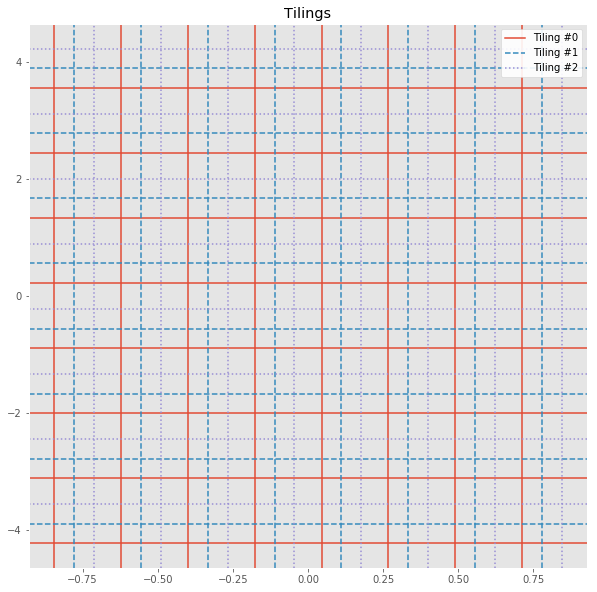

In [14]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


visualize_tilings(tilings);

Great! Now that we have a way to generate these tilings, we can next write our encoding function that will convert any given continuous state value to a discrete vector.

### 4. Tile Encoding

Implement the following to produce a vector that contains the indices for each tile that the input state value belongs to. The shape of the vector can be the same as the arrangment of tiles you have, or it can be ultimately flattened for convenience.

You can use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.

In [27]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    return tuple([int(np.digitize(_sample, _grid)) for _grid,_sample in zip(grid,sample)])


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    # TODO: Implement this
    vec = [discretize(sample, tiling) for tiling in tilings]
    if flatten:
        return [x for arr in vec for x in arr]
    return vec

# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
[[(0, 0), (0, 0), (0, 0)], [(1, 7), (1, 7), (0, 7)], [(2, 4), (2, 4), (1, 4)], [(5, 3), (5, 2), (5, 2)], [(5, 3), (5, 2), (4, 2)], [(8, 7), (7, 6), (7, 6)], [(7, 1), (7, 1), (7, 0)], [(8, 8), (8, 8), (8, 8)]]


Note that we did not flatten the encoding above, which is why each sample's representation is a pair of indices for each tiling. This makes it easy to visualize it using the tilings.

In [28]:
tilings

[[array([-0.844, -0.622, -0.399, -0.177,  0.045,  0.267,  0.49 ,  0.712]),
  array([-4.219, -3.108, -1.997, -0.886,  0.226,  1.337,  2.448,  3.559])],
 [array([-0.778, -0.556, -0.333, -0.111,  0.111,  0.333,  0.556,  0.778]),
  array([-3.889, -2.778, -1.667, -0.556,  0.556,  1.667,  2.778,  3.889])],
 [array([-0.712, -0.49 , -0.267, -0.045,  0.177,  0.399,  0.622,  0.844]),
  array([-3.559, -2.448, -1.337, -0.226,  0.886,  1.997,  3.108,  4.219])]]

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


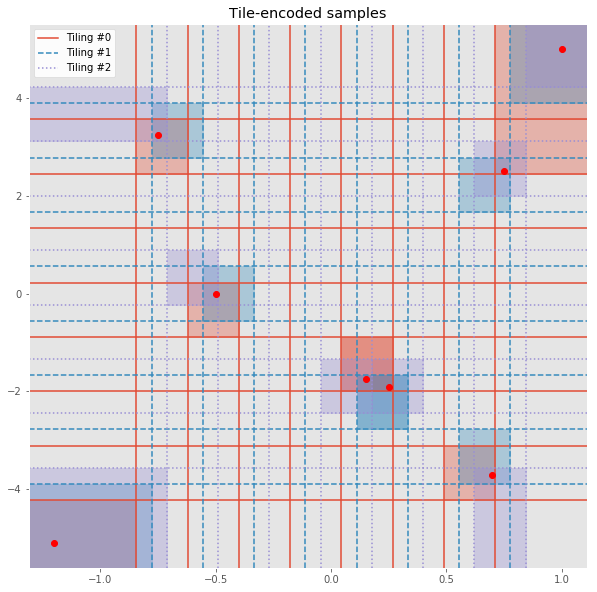

In [29]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing

    # Show tiling grids
    ax = visualize_tilings(tilings)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # Shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # So plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
    
    # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')

    ax.margins(x=0, y=0)  # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    return ax

visualize_encoded_samples(samples, encoded_samples, tilings);

Inspect the results and make sure you understand how the corresponding tiles are being chosen. Note that some samples may have one or more tiles in common.

### 5. Q-Table with Tile Coding

The next step is to design a special Q-table that is able to utilize this tile coding scheme. It should have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it should return a `<value>`. Similarly, it should also allow you to update the `<value>` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to).

The `<state>` supplied here is assumed to be from the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation when required.

In [30]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # TODO: Create Q-table, initialize all Q-values to zero
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        #Q table list for all the three tiles
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))
    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        # TODO: Retrieve q-value for each tiling, and return their average
        value = 0.0
        for en_state, q_table in zip(encoded_state, self.q_tables):
            value += q_table.q_table[tuple(en_state + (action,))]
        value /= len(self.q_tables)
        return value

    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # TODO: Encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        # TODO: Update q-value for each tiling by update factor alpha
        for en_state, q_table in zip(encoded_state, self.q_tables):
            value_ = q_table.q_table[tuple(en_state + (action,))]  # current value
            q_table.q_table[tuple(en_state + (action,))] = alpha*value + (1.0 - alpha)*value_        


# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

QTable(): size = (9, 9, 2)
QTable(): size = (9, 9, 2)
QTable(): size = (9, 9, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = 0.06666666666666667


If you update the q-value for a particular state (say, `(0.25, -1.91)`) and action (say, `0`), then you should notice the q-value of a nearby state (e.g. `(0.15, -1.75)` and same action) has changed as well! This is how tile-coding is able to generalize values across the state space better than a single uniform grid.

### 6. Implement a Q-Learning Agent using Tile-Coding

Now it's your turn to apply this discretization technique to design and test a complete learning agent! 